In [70]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt

In [44]:
players = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_players.csv', 
                      header=None, 
                      names=['player_id', 'first_name', 'last_name', 'hand', 'birthday','country_code'])

In [45]:
players

,player_id,first_name,last_name,hand,birthday,country_code
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA
...,...,...,...,...,...,...
54892,209858,Vladimir,Osminkin,U,NaN,RUS
54893,209859,Rostislav,Galfinger,U,20021112.0,KAZ
54894,209860,Ignacio,Buse,U,20040325.0,PER
54895,209861,Maj,Tomac,U,20010504.0,SLO


In [48]:
df = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_2019.csv')

In [49]:
list(df.columns.values)

['tourney_id',
 'tourney_name',
 'surface',
 'draw_size',
 'tourney_level',
 'tourney_date',
 'match_num',
 'winner_id',
 'winner_seed',
 'winner_entry',
 'winner_name',
 'winner_hand',
 'winner_ht',
 'winner_ioc',
 'winner_age',
 'loser_id',
 'loser_seed',
 'loser_entry',
 'loser_name',
 'loser_hand',
 'loser_ht',
 'loser_ioc',
 'loser_age',
 'score',
 'best_of',
 'round',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [76]:
# df2 = df[(df.loc[:,'winner_id'] == 105453 ) | (df.loc[:,'loser_id'] == 105453)]
df2 = df[df.loc[:,'winner_id'] == 105453]

In [77]:
df2.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,NaN,...,54.0,34.0,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,NaN,...,27.0,15.0,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0
6,2019-M020,Brisbane,Hard,32,A,20181231,294,105453,2,NaN,...,53.0,37.0,13.0,12.0,6.0,9.0,9.0,3590.0,19.0,1835.0
14,2019-M020,Brisbane,Hard,32,A,20181231,286,105453,2,NaN,...,36.0,26.0,8.0,10.0,4.0,7.0,9.0,3590.0,63.0,810.0
154,2019-580,Australian Open,Hard,128,G,20190114,115,105453,8,NaN,...,65.0,42.0,22.0,19.0,6.0,14.0,9.0,3750.0,176.0,291.0


In [78]:
df2 = df2.sort_values('tourney_date')

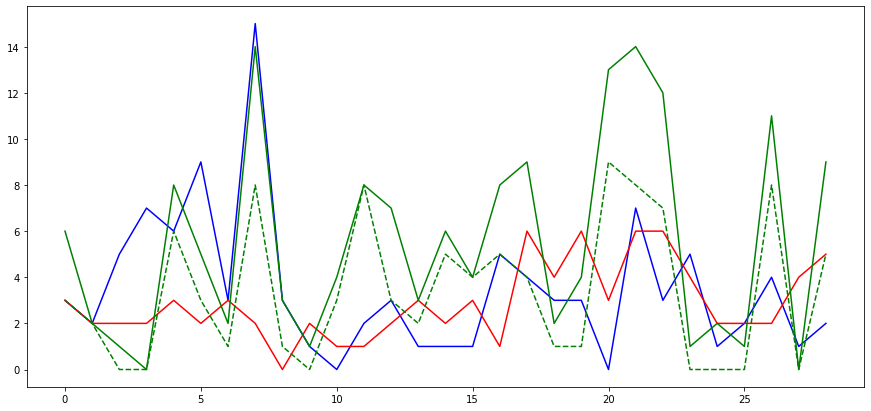

In [104]:
plt.figure(figsize=(15,7))
plt.plot(df2.w_ace.values, color='b')
plt.plot(df2.w_df.values, color='r')
plt.plot(df2.w_bpFaced.values, color='g')
plt.plot(df2.w_bpSaved.values, 'g--')
plt.show()

In [137]:
df2.shape

(29, 49)

In [138]:
segments = df2.shape[0]

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
x_full = pd.Series(df2.w_ace.values)

In [139]:
# X_tr.loc[0, 'mean'] = x.mean()

for segment in range(segments):
#     seg = train.iloc[segment*rows:segment*rows+rows]
#     x = pd.Series(seg['acoustic_data'].values)
#     y = seg['time_to_failure'].values[-1]
    
#     y_tr.loc[segment, 'time_to_failure'] = y

    #take all of x until that point in time
    x = x_full[:segment+1]
    
    #compute stats on this feature
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
#     X_tr.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
#     X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
#     X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
#     X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
#     X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
#     X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
#     X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
#     X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
#     X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
#     X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
#     X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
#     X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
#     X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
#     X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
#     X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
#     X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
#     X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
#     X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
#     X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
#     X_tr.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
#     X_tr.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
#     X_tr.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
#     X_tr.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
#     X_tr.loc[segment, 'trend'] = add_trend_feature(x)
#     X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
#     X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
#     X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
#     X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
#     X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
#     X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
#     X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
#     X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
#     X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
#     X_tr.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
#     X_tr.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
#     X_tr.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
#     X_tr.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
#     X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
#     ewma = pd.Series.ewm
#     X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
#     X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
#     X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
#     no_of_std = 3
#     X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
#     X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
#     X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
#     X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
#     X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
#     X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
#     X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
#     X_tr.drop('Moving_average_700_mean', axis=1, inplace=True)
    
#     X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
#     X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
#     X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
#     X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

#     for windows in [5, 10, 20]:
#         x_roll_std = x.rolling(windows).std().dropna().values
#         x_roll_mean = x.rolling(windows).mean().dropna().values
        
#         X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
#         X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
#         X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
#         X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
#         X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
#         X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
#         X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
#         X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
#         X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
#         X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
#         X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
#         X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
#         X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
#         X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
#         X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
#         X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
#         X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
#         X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
#         X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
#         X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
#         X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
#         X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()


In [141]:
X_tr = X_tr.fillna(value=0.0)
X_tr

,mean,std,max,min,mean_change_abs,abs_max,abs_min,max_to_min_diff,sum,q95,...,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,mad,kurt,skew,med
0,3.000000,0.000000,3.0,3.0,0.000000,3.0,3.0,0.0,3.0,3.00,...,3.00,3.00,3.00,3.00,3.00,3.00,0.000000,0.000000,0.000000,3.0
1,2.500000,0.707107,3.0,2.0,-1.000000,3.0,2.0,1.0,5.0,2.95,...,2.05,2.01,2.95,2.99,2.05,2.01,0.500000,0.000000,0.000000,2.5
2,3.333333,1.527525,5.0,2.0,1.000000,5.0,2.0,3.0,10.0,4.80,...,2.10,2.02,4.80,4.96,2.10,2.02,1.111111,0.000000,0.935220,3.0
3,4.250000,2.217356,7.0,2.0,1.333333,7.0,2.0,5.0,17.0,6.70,...,2.15,2.03,6.70,6.94,2.15,2.03,1.750000,-1.699512,0.481563,4.0
4,4.600000,2.073644,7.0,2.0,0.750000,7.0,2.0,5.0,23.0,6.80,...,2.20,2.04,6.80,6.96,2.20,2.04,1.680000,-1.963223,-0.235514,5.0
5,5.333333,2.581989,9.0,2.0,1.200000,9.0,2.0,7.0,32.0,8.50,...,2.25,2.05,8.50,8.90,2.25,2.05,2.000000,-0.867000,0.077460,5.5
6,5.000000,2.516611,9.0,2.0,0.000000,9.0,2.0,7.0,35.0,8.40,...,2.30,2.06,8.40,8.88,2.30,2.06,2.000000,-0.909141,0.439187,5.0
7,6.250000,4.234214,15.0,2.0,1.714286,15.0,2.0,13.0,50.0,12.90,...,2.35,2.07,12.90,14.58,2.35,2.07,3.062500,2.002457,1.364336,5.5
8,5.888889,4.106228,15.0,2.0,0.000000,15.0,2.0,13.0,53.0,12.60,...,2.40,2.08,12.60,14.52,2.40,2.08,2.987654,2.423787,1.522694,5.0
9,5.400000,4.168666,15.0,1.0,-0.222222,15.0,1.0,14.0,54.0,12.30,...,1.45,1.09,12.30,14.46,1.45,1.09,3.080000,2.364801,1.475660,4.0


In [15]:
def readAllFiles(dirname):
    allFiles = glob.glob(dirname + "/atp_rankings_" + "*20*.csv")
    ranks = pd.DataFrame()
    list_ = list()
    for filen in allFiles:
        df = pd.read_csv(filen,
                         index_col=None,
                         header=None,
                         parse_dates=[0],
                         date_parser=lambda t:parse(t))
        list_.append(df)
    ranks = pd.concat(list_)
    return ranks

In [12]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import datetime, sys

# pd.options.display.mpl_style = 'default'

def parse(t):
    string_ = str(t)
    try:
        return datetime.date(int(string_[:4]), int(string[4:6]), int(string[6:]))
    except:
        print("Erro",len(string_))
        return datetime.date(1900,1,1)
    
def readAllFiles(dirname):
    allFiles = glob.glob(dirname + "/atp_rankings_" + "*.csv")
    ranks = pd.DataFrame()
    list_ = list()
    for filen in allFiles:
        print(filen)
        df = pd.read_csv(filen,
                         index_col=None,
                         header=None,
                         parse_dates=[0],
                         date_parser=lambda t:parse(t))
        list_.append(df)
    ranks = pd.concat(list_)
    return ranks

def readPlayers(dirname):
    print ("Reading Players")
    return pd.read_csv(dirname+"/atp_players.csv",
                       index_col=None,
                       header=None,
                       parse_dates=[4],
                       date_parser=lambda t:parse(t))


# ranks = readAllFiles(sys.argv[1])
# ranks = ranks[(ranks[1]<100)]
# print ranks
# players = readPlayers (sys.argv[1])
# plRanks = ranks.merge(players,right_on=0,left_on=2)
# plRanks["B"] = plRanks["0_x"] - plRanks[4]
# plRanks["B"] = plRanks["B"].astype(int) / (365*24*3600*1000000000.0)
# agg = plRanks[["0_x","B"]].groupby("0_x")

# agg.mean().to_csv("top100ages.csv")